Link:

https://github.com/utkd/gans/blob/master/cifar10dcgan.ipynb

In [1]:
from __future__ import print_function, division

from keras.layers import Input, Dense, Flatten, Dropout, Reshape
from keras.layers import BatchNormalization, Activation, Conv2D, Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.optimizers import Adam

from keras.datasets import cifar10
import keras.backend as K

import matplotlib.pyplot as plt

import sys
import numpy as np

%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [2]:
def get_generator(input_layer):
  '''
  Requires the input layer as input, outputs the model and the final layer
  '''
  alpha = 0.19
  momentum = 0.92
    
  hid = Dense(128 * 16 * 16, activation='relu')(input_layer)    
  hid = BatchNormalization(momentum=momentum)(hid)
  hid = LeakyReLU(alpha=alpha)(hid)
  hid = Reshape((16, 16, 128))(hid)

  hid = Conv2D(128, kernel_size=5, strides=1,padding='same')(hid)
  hid = BatchNormalization(momentum=momentum)(hid)    
  #hid = Dropout(0.5)(hid)
  hid = LeakyReLU(alpha=alpha)(hid)

  hid = Conv2DTranspose(128, 4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=momentum)(hid)
  hid = LeakyReLU(alpha=alpha)(hid)

  hid = Conv2D(128, kernel_size=5, strides=1, padding='same')(hid)
  hid = BatchNormalization(momentum=momentum)(hid)
  #hid = Dropout(0.5)(hid)
  hid = LeakyReLU(alpha=alpha)(hid)

  hid = Conv2D(128, kernel_size=5, strides=1, padding='same')(hid)
  hid = BatchNormalization(momentum=momentum)(hid)
  hid = LeakyReLU(alpha=alpha)(hid)
                      
  hid = Conv2D(3, kernel_size=5, strides=1, padding="same")(hid)
  out = Activation("tanh")(hid)

  model = Model(input_layer, out)
  model.summary()
  
  return model, out

In [3]:
def get_discriminator(input_layer):
  '''
  Requires the input layer as input, outputs the model and the final layer
  '''

  alpha = 0.19
  momentum = 0.92

  hid = Conv2D(128, kernel_size=3, strides=1, padding='same')(input_layer)
  hid = BatchNormalization(momentum=momentum)(hid)
  hid = LeakyReLU(alpha=alpha)(hid)

  hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=momentum)(hid)
  hid = LeakyReLU(alpha=alpha)(hid)

  hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=momentum)(hid)
  hid = LeakyReLU(alpha=alpha)(hid)

  hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=momentum)(hid)
  hid = LeakyReLU(alpha=alpha)(hid)

  hid = Flatten()(hid)
  hid = Dropout(0.4)(hid)
  out = Dense(1, activation='sigmoid')(hid)

  model = Model(input_layer, out)

  model.summary()

  return model, out

In [4]:
# Image processing
from keras.preprocessing import image

def generate_noise(n_samples, noise_dim):
  X = np.random.normal(0, 1, size=(n_samples, noise_dim))
  return X

def show_imgs(batchidx):
  noise = generate_noise(9, 100)
  gen_imgs = generator.predict(noise)

  fig, axs = plt.subplots(3, 3)
  count = 0
  for i in range(3):
    for j in range(3):
      # Dont scale the images back, let keras handle it
      img = image.array_to_img(gen_imgs[count], scale=True)
      axs[i,j].imshow(img)
      axs[i,j].axis('off')
      count += 1
  plt.show()
  plt.close()

In [5]:
# GAN creation
img_input = Input(shape=(32,32,3))
discriminator, disc_out = get_discriminator(img_input)
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

discriminator.trainable = False

noise_input = Input(shape=(100,))
generator, gen_out = get_generator(noise_input)

gan_input = Input(shape=(100,))
x = generator(gan_input)
gan_out = discriminator(x)
gan = Model(gan_input, gan_out)
gan.summary()

gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       3584      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       262272    
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 128)       0         
__________

In [6]:
BATCH_SIZE = 16

# Load in cifar 10
# Get training images
(X_train, y_train), (X_test, _) = cifar10.load_data()

# Select Cars(1) 
X_train = X_train[y_train[:,0]==1]
print ("Training shape: {}".format(X_train.shape))

# Normalize data
X_train = (X_train - 127.5) / 127.5
 
num_batches = int(X_train.shape[0]/BATCH_SIZE)

Training shape: (5000, 32, 32, 3)


C:\0_STORAGE\Programs\Anaconda3\envs\hyper\lib\site-packages\keras\engine\training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


  Epoch: 1, Generator Loss: 1.1220551924302409, Discriminator Loss: [0.33664358 0.        ]


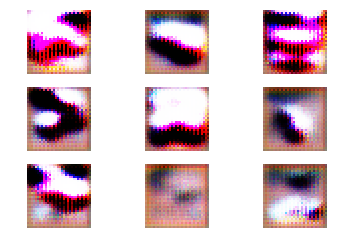

  Epoch: 2, Generator Loss: 1.8947075570049958, Discriminator Loss: [0.40758616 0.        ]


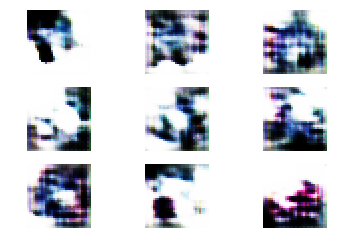

  Epoch: 3, Generator Loss: 1.211133329364925, Discriminator Loss: [0.4305005 0.       ]


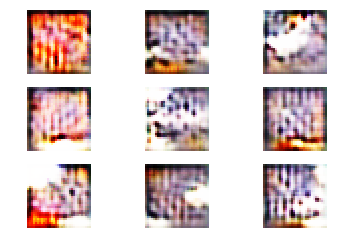

  Epoch: 4, Generator Loss: 1.1515276511438572, Discriminator Loss: [0.36811972 0.        ]


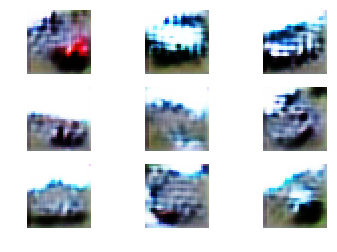

  Epoch: 5, Generator Loss: 1.2190487990991619, Discriminator Loss: [0.41044572 0.        ]


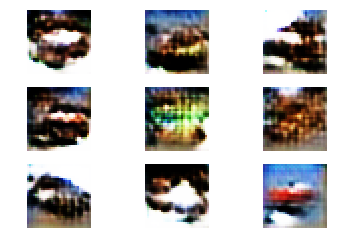

  Epoch: 6, Generator Loss: 1.248835825910553, Discriminator Loss: [0.44421554 0.        ]


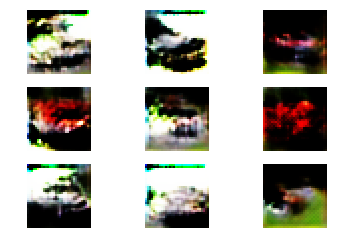

  Epoch: 7, Generator Loss: 1.279163262168041, Discriminator Loss: [0.45337003 0.        ]


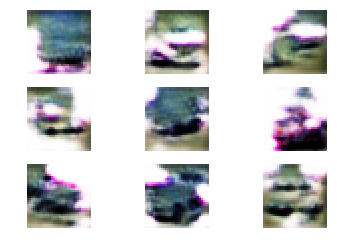

  Epoch: 8, Generator Loss: 1.2089982038984697, Discriminator Loss: [0.4622152 0.       ]


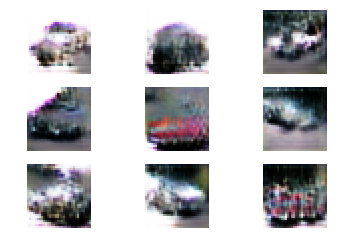

  Epoch: 9, Generator Loss: 1.1192445777690945, Discriminator Loss: [0.4131633 0.       ]


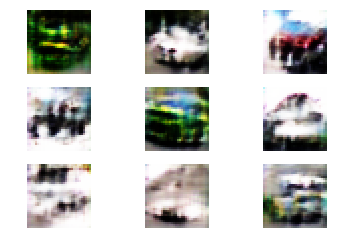

  Epoch: 10, Generator Loss: 1.0362575113033063, Discriminator Loss: [0.42536125 0.        ]


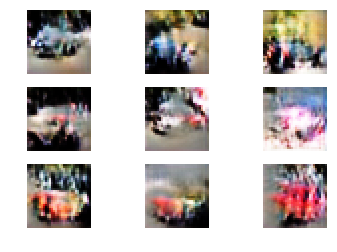

  Epoch: 11, Generator Loss: 1.241475094205294, Discriminator Loss: [0.38053778 0.        ]


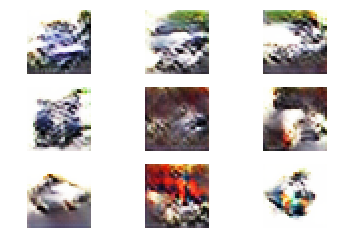

  Epoch: 12, Generator Loss: 1.0357396446096783, Discriminator Loss: [0.45348963 0.        ]


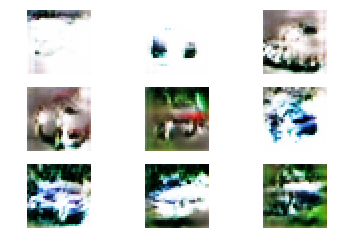

  Epoch: 13, Generator Loss: 1.177842067196392, Discriminator Loss: [0.4943296 0.       ]


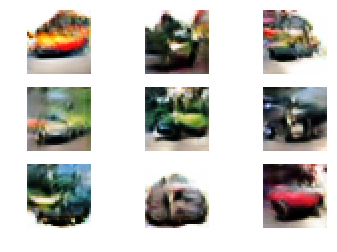

  Epoch: 14, Generator Loss: 1.079817299062434, Discriminator Loss: [0.50676715 0.        ]


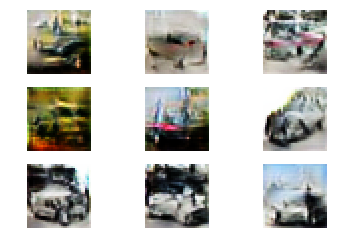

  Epoch: 15, Generator Loss: 1.1198088731139133, Discriminator Loss: [0.47791955 0.        ]


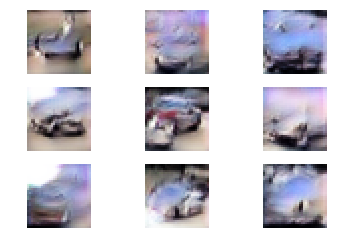

  Epoch: 16, Generator Loss: 1.1402820691657372, Discriminator Loss: [0.5414134 0.       ]


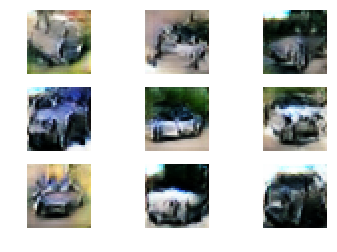

  Epoch: 17, Generator Loss: 1.1576040518255188, Discriminator Loss: [0.48622978 0.        ]


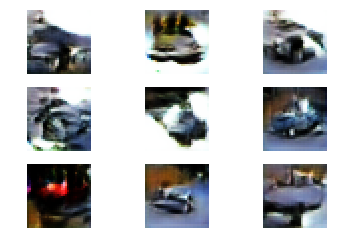

  Epoch: 18, Generator Loss: 1.088947963136702, Discriminator Loss: [0.57481396 0.        ]


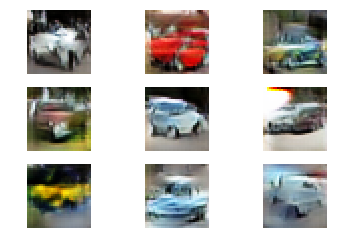

  Epoch: 19, Generator Loss: 0.9694533868191334, Discriminator Loss: [0.50223255 0.        ]


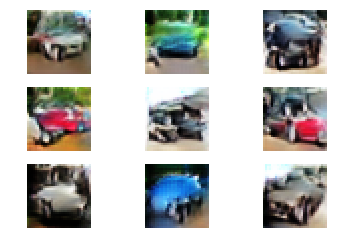

  Epoch: 20, Generator Loss: 1.045129804071994, Discriminator Loss: [0.5460291 0.       ]


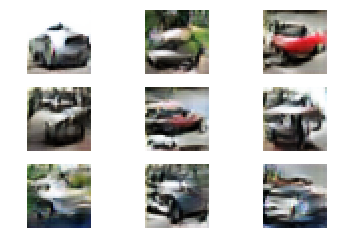

In [7]:
N_EPOCHS = 20
for epoch in range(N_EPOCHS):

  cum_d_loss = 0.
  cum_g_loss = 0.
  
  for batch_idx in range(num_batches):
    # Get the next set of real images to be used in this iteration
    images = X_train[batch_idx*BATCH_SIZE : (batch_idx+1)*BATCH_SIZE]

    noise_data = generate_noise(BATCH_SIZE, 100)
    generated_images = generator.predict(noise_data)

    # Train on soft labels (add noise to labels as well)
    noise_prop = 0.05 # Randomly flip 5% of labels
    
    # Prepare labels for real data
    true_labels = np.zeros((BATCH_SIZE, 1)) + np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
    flipped_idx = np.random.choice(np.arange(len(true_labels)), size=int(noise_prop*len(true_labels)))
    true_labels[flipped_idx] = 1 - true_labels[flipped_idx]
    
    # Train discriminator on real data
    d_loss_true = discriminator.train_on_batch(images, true_labels)

    # Prepare labels for generated data
    gene_labels = np.ones((BATCH_SIZE, 1)) - np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
    flipped_idx = np.random.choice(np.arange(len(gene_labels)), size=int(noise_prop*len(gene_labels)))
    gene_labels[flipped_idx] = 1 - gene_labels[flipped_idx]
    
    # Train discriminator on generated data
    d_loss_gene = discriminator.train_on_batch(generated_images, gene_labels)

    d_loss = 0.5 * np.add(d_loss_true, d_loss_gene)
    cum_d_loss += d_loss

    # Train generator
    noise_data = generate_noise(BATCH_SIZE, 100)
    g_loss = gan.train_on_batch(noise_data, np.zeros((BATCH_SIZE, 1)))
    cum_g_loss += g_loss

  print('  Epoch: {}, Generator Loss: {}, Discriminator Loss: {}'.format(epoch+1, cum_g_loss/num_batches, cum_d_loss/num_batches))
  show_imgs("epoch" + str(epoch))